### Visual Attention Mechanism


Reference:
[EscVM_YT/Notebooks/0 - TF2.X Tutorials
/tf_2_visual_attention.ipynb](https://github.com/EscVM/EscVM_YT/blob/master/Notebooks/0%20-%20TF2.X%20Tutorials/tf_2_visual_attention.ipynb)

`Some parts of the code were modified and comment lines were added.`

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
'''
physical_devices = tf.config.experimental.list_physical_devices('GPU')

try:
  # Disable first GPU
  tf.config.set_visible_devices(physical_devices[0:], 'GPU')
  logical_devices = tf.config.list_logical_devices('GPU')
  print(physical_devices)
  # Logical device was not created for first GPU
  assert len(logical_devices) == len(physical_devices) - 1
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  print("Invalid device or cannot modify virtual devices once initialized.")
  pass
'''

'\nphysical_devices = tf.config.experimental.list_physical_devices(\'GPU\')\n\ntry:\n  # Disable first GPU\n  tf.config.set_visible_devices(physical_devices[0:], \'GPU\')\n  logical_devices = tf.config.list_logical_devices(\'GPU\')\n  print(physical_devices)\n  # Logical device was not created for first GPU\n  assert len(logical_devices) == len(physical_devices) - 1\n  tf.config.experimental.set_memory_growth(physical_devices[0], True)\nexcept:\n  print("Invalid device or cannot modify virtual devices once initialized.")\n  pass\n'

![](https://raw.githubusercontent.com/EscVM/EscVM_YT/fd7f3f0798d40c3097690133778df82b26a0d96d/Notebooks/0%20-%20TF2.X%20Tutorials/media/tf_tutorial_2/yoshua_paper_results.png)

Reference: [Neural Machine Translation by Jointly Learning to Align and Translate
](https://arxiv.org/abs/1409.0473)

![](https://raw.githubusercontent.com/EscVM/EscVM_YT/fd7f3f0798d40c3097690133778df82b26a0d96d/Notebooks/0%20-%20TF2.X%20Tutorials/media/tf_tutorial_2/attention_examples.png)

Reference:
[Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044)

![](https://raw.githubusercontent.com/EscVM/EscVM_YT/fd7f3f0798d40c3097690133778df82b26a0d96d/Notebooks/0%20-%20TF2.X%20Tutorials/media/tf_tutorial_2/se_example_2.png)

Reference:
[Squeeze-and-Excitation Networks](https://arxiv.org/abs/1709.01507)

![](https://raw.githubusercontent.com/EscVM/EscVM_YT/fd7f3f0798d40c3097690133778df82b26a0d96d/Notebooks/0%20-%20TF2.X%20Tutorials/media/tf_tutorial_2/cbam_example_1.png)

![](https://raw.githubusercontent.com/EscVM/EscVM_YT/fd7f3f0798d40c3097690133778df82b26a0d96d/Notebooks/0%20-%20TF2.X%20Tutorials/media/tf_tutorial_2/cbam_example_2.png)

Reference:
[CBAM: Convolutional Block Attention Module](https://arxiv.org/abs/1807.06521)

In [3]:
import os

os.makedirs('utils/', exist_ok=True)
os.chdir('utils')

! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/vision.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/callbacks.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/utils.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/attention_modules.py

os.chdir('/content')
print("Current working directory", os.getcwd())

Current working directory /content


In [4]:
from utils import vision
from utils import utils
from utils import losses
from utils.attention_modules import Conv2DLayerBN, Conv2DLayerRes, ChannelGate, SpatialGate, CBAM

In [5]:
experiment = {
    'IMAGE_SIZE': (32, 32),
    'INPUT_SHAPE': (32, 32, 3),

    'ACCELERATOR': 'GPU',  # Or 'TPU'

    'BATCH_SIZE': 32,
    'EPOCHS': 20,
    'AUTOTUNE': tf.data.experimental.AUTOTUNE,
    'OPTIMIZER': 'Adam',  # TODO: Try 'rmsprop' optimizer
    'LEARNING_RATE': 0.0001,  # 1e-4

    # Record directory of model's trained weights
    'TRAINING_WEIGHT_DIR': "tf_visual_attention_mechanism/training_weights",
    # Record directory of generated images
    'IMGS_DIR': "tf_visual_attention_mechanism/images",
}

### Build a Model

In [6]:
(ds_train, ds_test), ds_info = tfds.load('cifar10', split=['train', 'test'],
                                      shuffle_files=True, as_supervised=True,
                                      with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteSOLPUA/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteSOLPUA/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [7]:
ds_info

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir=PosixGPath('/tmp/tmpzo58djnytfds'),
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning mult

In [8]:
ds_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
ds_info.features['label'].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [10]:
def visualize_images(image_batch):
  index = 0
  for image, label in image_batch.take(10):
    plt.subplot(2, 5, index + 1)
    index += 1
    plt.imshow(image[:])
    plt.axis('off')
  plt.tight_layout()
  plt.show()

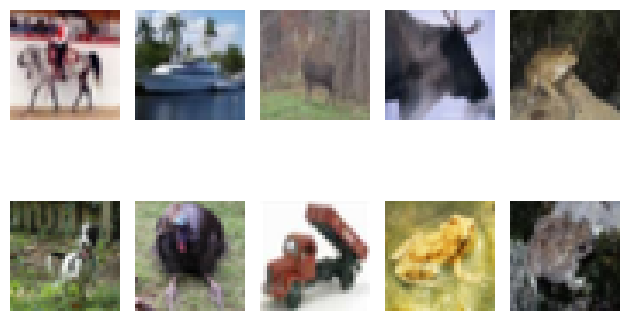

In [11]:
visualize_images(ds_train)

In [12]:
def normalize(image, label):
  return tf.cast(image, tf.float32) / 255.0, label

### Prepare Dataset

In [13]:
ds_train = ds_train.map(normalize, num_parallel_calls=experiment['AUTOTUNE'])
ds_train = ds_train.cache().shuffle(ds_info.splits['train'].num_examples).batch(experiment['BATCH_SIZE']).prefetch(experiment['AUTOTUNE'])

In [14]:
ds_test = ds_test.map(normalize, num_parallel_calls=experiment['AUTOTUNE'])
ds_test = ds_test.cache().batch(experiment['BATCH_SIZE']).prefetch(experiment['AUTOTUNE'])

### Build a Network without Attention

In [15]:
def get_cnn_model_without_attention(verbose=0):
    input = tf.keras.layers.Input(shape=ds_info.features['image'].shape, name='Input_Layer')
    x = Conv2DLayerBN(32, 3, strides=1, padding="same", act_end='relu')(input)
    x = Conv2DLayerBN(32, 3, strides=1, padding="same", act_end='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2DLayerBN(64, 3, strides=1, padding="same", act_end='relu')(x)
    x = Conv2DLayerBN(64, 3, strides=1, padding="same", act_end='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2DLayerBN(128, 3, strides=1, padding="same", act_end='relu')(x)
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    # No batch normalization after last Conv block

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    output = tf.keras.layers.Dense(ds_info.features['label'].num_classes,
                              activation='softmax' )(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    if verbose > 0:  model.summary()
    return model

In [16]:
'''
# Equivalent code using Sequential API
def get_cnn_model_without_attention(verbose=0):
    model = tf.keras.models.Sequential([
        Conv2DLayerBN(32, 3, input_shape=ds_info.features['image'].shape,
                      act_end='relu', padding='same', batch_norm=True),
        Conv2DLayerBN(32, 3, padding='same', act_end='relu', batch_norm=True),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        Conv2DLayerBN(64, 3, padding='same', act_end='relu', batch_norm=True),
        Conv2DLayerBN(64, 3, padding='same', act_end='relu', batch_norm=True),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        Conv2DLayerBN(128, 3, padding='same', act_end='relu', batch_norm=True),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax' )
    ])

    if verbose > 0:  model.summary()
    return model
'''

"\n# Equivalent code using Sequential API\ndef get_cnn_model_without_attention(verbose=0):\n    model = tf.keras.models.Sequential([\n        Conv2DLayerBN(32, 3, input_shape=ds_info.features['image'].shape,\n                      act_end='relu', padding='same', batch_norm=True),\n        Conv2DLayerBN(32, 3, padding='same', act_end='relu', batch_norm=True),\n        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),\n        Conv2DLayerBN(64, 3, padding='same', act_end='relu', batch_norm=True),\n        Conv2DLayerBN(64, 3, padding='same', act_end='relu', batch_norm=True),\n        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),\n        Conv2DLayerBN(128, 3, padding='same', act_end='relu', batch_norm=True),\n        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),\n        tf.keras.layers.GlobalAveragePooling2D(),\n        tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax' )\n    ])\n\n    if verbose > 0:  model.summary()\n    return mode

In [17]:
simple_cnn_no_attention = get_cnn_model_without_attention(verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_layer_bn (Conv2DLay  (None, 32, 32, 32)        1024      
 erBN)                                                           
                                                                 
 conv2d_layer_bn_1 (Conv2DL  (None, 32, 32, 32)        9376      
 ayerBN)                                                         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_layer_bn_2 (Conv2DL  (None, 16, 16, 64)        18752     
 ayerBN)                                                     

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001)

In [ ]:
simple_cnn_no_attention.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

In [ ]:
model_hist = simple_cnn_no_attention.fit(ds_train, epochs=experiment['EPOCHS'])

Epoch 1/20
1563/1563 [==============================] - 18s 8ms/step - loss: 1.2241 - accuracy: 0.5587
Epoch 2/20
1563/1563 [==============================] - 13s 8ms/step - loss: 0.7818 - accuracy: 0.7286
Epoch 3/20
1563/1563 [==============================] - 13s 8ms/step - loss: 0.6239 - accuracy: 0.7825
Epoch 4/20
1563/1563 [==============================] - 13s 8ms/step - loss: 0.5203 - accuracy: 0.8205
Epoch 5/20
1563/1563 [==============================] - 13s 8ms/step - loss: 0.4454 - accuracy: 0.8456
Epoch 6/20
1563/1563 [==============================] - 12s 8ms/step - loss: 0.3761 - accuracy: 0.8702
Epoch 7/20
1563/1563 [==============================] - 12s 8ms/step - loss: 0.3301 - accuracy: 0.8844
Epoch 8/20
1563/1563 [==============================] - 13s 8ms/step - loss: 0.2774 - accuracy: 0.9032
Epoch 9/20
1563/1563 [==============================] - 12s 8ms/step - loss: 0.2401 - accuracy: 0.9158
Epoch 10/20
1563/1563 [==============================] - 12s 8ms/step - l

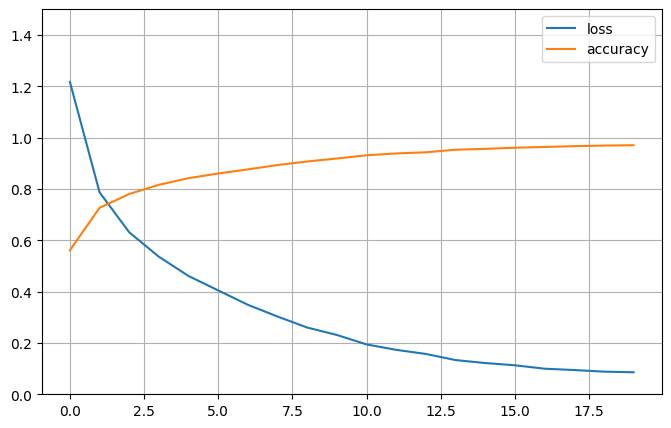

In [ ]:
import pandas as pd

pd.DataFrame(model_hist.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)
plt.show()

In [ ]:
print(f"Test accuracy: {simple_cnn_no_attention.evaluate(ds_test)[1]}")

313/313 [==============================] - 3s 10ms/step - loss: 1.1100 - accuracy: 0.7842
Test accuracy: 0.7842000126838684


### Build a Network with Attention

In [18]:
def get_cnn_model_with_attention_block(verbose=0):
    input = tf.keras.layers.Input(shape=ds_info.features['image'].shape, name='Input_Layer')
    x = Conv2DLayerRes(32, 3, strides=1, padding="same", act_end='relu')(input)
    x = Conv2DLayerRes(32, 3, strides=1, padding="same", act_end='relu')(x)

    #x = CBAM(gate_channels=32, reduction_ratio=8)(x)
    x = x + tf.keras.layers.Attention()([x,x])
    # Equivalent code of CBAM (Convolutional Block Attention Module)
    # x = ChannelGate(32, 8)(x)
    # x = SpatialGate(7)(x)

    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2DLayerRes(64, 3, strides=1, padding="same", act_end='relu')(x)
    x = Conv2DLayerRes(64, 3, strides=1, padding="same", act_end='relu')(x)

    #x = CBAM(gate_channels=64, reduction_ratio=8)(x)
    x = x + tf.keras.layers.Attention()([x,x])

    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2DLayerRes(128, 3, strides=1, padding="same", act_end='relu')(x)
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    # No batch normalization after last Conv block

    #x = CBAM(gate_channels=128, reduction_ratio=8)(x)
    x = x + tf.keras.layers.Attention()([x,x])

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    output = tf.keras.layers.Dense(ds_info.features['label'].num_classes,
                              activation='softmax' )(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    if verbose > 0:  model.summary()
    return model

In [19]:
'''
# Equivalent code using Sequential API
def get_cnn_model_with_attention_block(verbose=0):
    model = tf.keras.Sequential([
    Conv2DLayerBN(32, 3, input_shape=ds_info.features['image'].shape,
                  act_end='relu', padding='same'),
    Conv2DLayerBN(32, 3, padding='same', act_end='relu'),

    CBAM(gate_channels=32, reduction_ratio=8),
    # Equivalent code of CBAM (Convolutional Block Attention Module)
    # ChannelGate(32, 8),
    # SpatialGate(7),

    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    Conv2DLayerBN(64, 3, padding='same', act_end='relu'),
    Conv2DLayerBN(64, 3, padding='same', act_end='relu'),

    CBAM(gate_channels=64, reduction_ratio=8),
    # ChannelGate(64, 8),
    # SpatialGate(7),

    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    Conv2DLayerBN(128, 3, padding='same', act_end='relu'),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),

    CBAM(gate_channels=128, reduction_ratio=8),
    # ChannelGate(128, 8),
    # SpatialGate(7),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax' )
    ])
    if verbose > 0:  model.summary()

    return model
'''

"\n# Equivalent code using Sequential API\ndef get_cnn_model_with_attention_block(verbose=0):\n    model = tf.keras.Sequential([\n    Conv2DLayerBN(32, 3, input_shape=ds_info.features['image'].shape,\n                  act_end='relu', padding='same'),\n    Conv2DLayerBN(32, 3, padding='same', act_end='relu'),\n\n    CBAM(gate_channels=32, reduction_ratio=8),\n    # Equivalent code of CBAM (Convolutional Block Attention Module)\n    # ChannelGate(32, 8),\n    # SpatialGate(7),\n\n    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),\n    Conv2DLayerBN(64, 3, padding='same', act_end='relu'),\n    Conv2DLayerBN(64, 3, padding='same', act_end='relu'),\n\n    CBAM(gate_channels=64, reduction_ratio=8),\n    # ChannelGate(64, 8),\n    # SpatialGate(7),\n\n    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),\n    Conv2DLayerBN(128, 3, padding='same', act_end='relu'),\n    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),\n\n    CBAM(gate_channels=128, reduction_ratio=8),\n    # C

In [20]:
simple_cnn_with_attention = get_cnn_model_with_attention_block(verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_layer_res (Conv2DLa  (None, 32, 32, 32)           10656     ['Input_Layer[0][0]']         
 yerRes)                                                                                          
                                                                                                  
 conv2d_layer_res_1 (Conv2D  (None, 32, 32, 32)           19936     ['conv2d_layer_res[0][0]']    
 LayerRes)                                                                                        
                                                                                            

In [21]:
simple_cnn_with_attention.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [22]:
history = simple_cnn_with_attention.fit(ds_train, epochs=experiment['EPOCHS'])

Epoch 1/20
1563/1563 [==============================] - 55s 19ms/step - loss: 1.3801 - accuracy: 0.4982
Epoch 2/20
1563/1563 [==============================] - 25s 16ms/step - loss: 0.9402 - accuracy: 0.6656
Epoch 3/20
1563/1563 [==============================] - 25s 16ms/step - loss: 0.7356 - accuracy: 0.7430
Epoch 4/20
1563/1563 [==============================] - 26s 16ms/step - loss: 0.6096 - accuracy: 0.7880
Epoch 5/20
1563/1563 [==============================] - 26s 16ms/step - loss: 0.5270 - accuracy: 0.8175
Epoch 6/20
1563/1563 [==============================] - 26s 16ms/step - loss: 0.4588 - accuracy: 0.8412
Epoch 7/20
1563/1563 [==============================] - 25s 16ms/step - loss: 0.4096 - accuracy: 0.8559
Epoch 8/20
1563/1563 [==============================] - 24s 15ms/step - loss: 0.3633 - accuracy: 0.8740
Epoch 9/20
1563/1563 [==============================] - 24s 16ms/step - loss: 0.3237 - accuracy: 0.8867
Epoch 10/20
1563/1563 [==============================] - 25s 16m

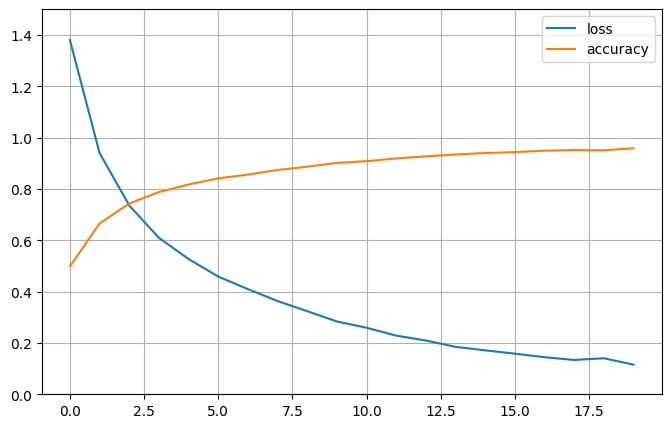

In [23]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)
plt.show()

In [24]:
print(f"Test accuracy: {simple_cnn_with_attention.evaluate(ds_test)[1]}")

313/313 [==============================] - 5s 14ms/step - loss: 0.5938 - accuracy: 0.8498
Test accuracy: 0.8497999906539917


In [25]:
def get_cnn_model_with_CBAM_attention(verbose=0):
    input = tf.keras.layers.Input(shape=ds_info.features['image'].shape, name='Input_Layer')
    x = Conv2DLayerRes(32, 3, strides=1, padding="same", act_end='relu')(input)
    x = Conv2DLayerRes(32, 3, strides=1, padding="same", act_end='relu')(x)

    x = CBAM(gate_channels=32, reduction_ratio=8)(x)
    # Equivalent code of CBAM (Convolutional Block Attention Module)
    # x = ChannelGate(32, 8)(x)
    # x = SpatialGate(7)(x)

    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2DLayerRes(64, 3, strides=1, padding="same", act_end='relu')(x)
    x = Conv2DLayerRes(64, 3, strides=1, padding="same", act_end='relu')(x)

    x = CBAM(gate_channels=64, reduction_ratio=8)(x)

    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2DLayerRes(128, 3, strides=1, padding="same", act_end='relu')(x)
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    # No batch normalization after last Conv block

    x = CBAM(gate_channels=128, reduction_ratio=8)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    output = tf.keras.layers.Dense(ds_info.features['label'].num_classes,
                              activation='softmax' )(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    if verbose > 0:  model.summary()
    return model

In [26]:
simple_cnn_with_cbam_attention = get_cnn_model_with_CBAM_attention(verbose=1)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_layer_res_5 (Conv2D  (None, 32, 32, 32)        10656     
 LayerRes)                                                       
                                                                 
 conv2d_layer_res_6 (Conv2D  (None, 32, 32, 32)        19936     
 LayerRes)                                                       
                                                                 
 cbam (CBAM)                 (None, 32, 32, 32)        395       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                           

In [27]:
simple_cnn_with_cbam_attention.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [28]:
history = simple_cnn_with_cbam_attention.fit(ds_train, epochs=experiment['EPOCHS'])

Epoch 1/20
1563/1563 [==============================] - 46s 22ms/step - loss: 1.2897 - accuracy: 0.5294
Epoch 2/20
1563/1563 [==============================] - 34s 22ms/step - loss: 0.8427 - accuracy: 0.7016
Epoch 3/20
1563/1563 [==============================] - 34s 21ms/step - loss: 0.6591 - accuracy: 0.7698
Epoch 4/20
1563/1563 [==============================] - 33s 21ms/step - loss: 0.5471 - accuracy: 0.8105
Epoch 5/20
1563/1563 [==============================] - 32s 21ms/step - loss: 0.4703 - accuracy: 0.8360
Epoch 6/20
1563/1563 [==============================] - 33s 21ms/step - loss: 0.4052 - accuracy: 0.8572
Epoch 7/20
1563/1563 [==============================] - 32s 20ms/step - loss: 0.3567 - accuracy: 0.8783
Epoch 8/20
1563/1563 [==============================] - 33s 21ms/step - loss: 0.3095 - accuracy: 0.8923
Epoch 9/20
1563/1563 [==============================] - 32s 20ms/step - loss: 0.2673 - accuracy: 0.9065
Epoch 10/20
1563/1563 [==============================] - 33s 21m

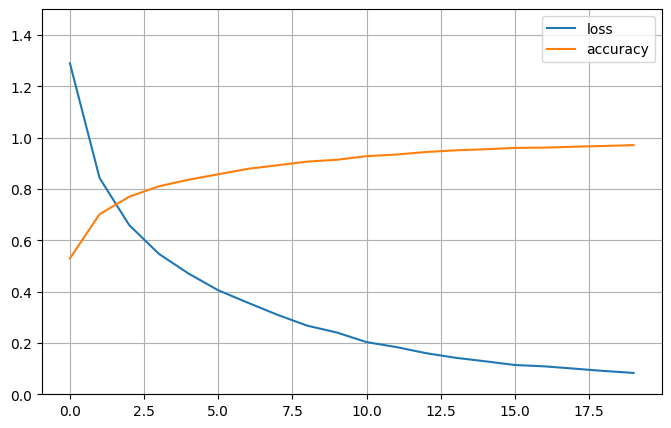

In [29]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)
plt.show()

In [31]:
print(f"Test accuracy: {simple_cnn_with_cbam_attention.evaluate(ds_test)[1]}")

313/313 [==============================] - 2s 6ms/step - loss: 0.6932 - accuracy: 0.8239
Test accuracy: 0.8238999843597412


### Visualize Attention network

In [32]:
for images, labels in tfds.as_numpy(ds_test.take(1)):
    X_test = images
    y_test = labels

print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_test.shape: (32, 32, 32, 3)
y_test.shape: (32,)


In [33]:
def image_to_uint_255(image):
    """
    Convert float images to int 0-255 images.
    Args:
        image (numpy.ndarray): Input image. Can be either [0, 255], [0, 1], [-1, 1]
    Returns:
        numpy.ndarray:
    """
    if image.dtype == np.uint8:
        return image

    if image.min() < 0:
        image = (image + 1.0) / 2.0

    return (image * 255).astype("uint8")

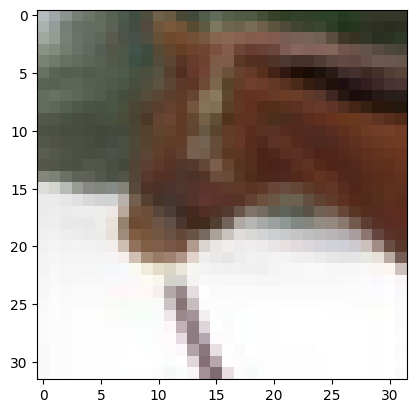

In [34]:
plt.imshow(X_test[0])

### Network without vs with Attention

1/1 [==============================] - 1s 562ms/step


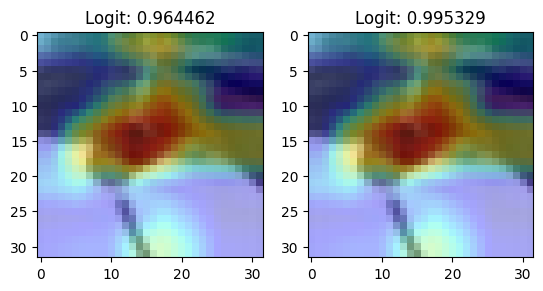

In [35]:
test_id = 0

test_img = X_test[test_id]
test_img = tf.expand_dims(test_img, axis=0)

# CNN model with Attention
gradCam_att_cnn = vision.GradCAM(simple_cnn_with_attention)
preds_att_cnn = simple_cnn_with_attention.predict(X_test)
class_id_att_cnn = np.argmax(preds_att_cnn[test_id])
(heatmap_att_cnn, output_att_cnn) = gradCam_att_cnn(test_img, X_test[test_id]*255, class_id_att_cnn, alpha=0.5)


# Simple CNN model
gradCam_cnn = vision.GradCAM(simple_cnn_with_cbam_attention)
preds_cnn = simple_cnn_with_cbam_attention.predict(X_test)
class_id_cnn = np.argmax(preds_cnn[test_id])
(heatmap_cnn, output_cnn) = gradCam_att_cnn(test_img, X_test[test_id]*255, class_id_cnn, alpha=0.5)


plt.subplot(1,2,1)
plt.imshow(output_att_cnn)
plt.title(f"Logit: {preds_att_cnn[0][class_id_att_cnn]:2f}")
plt.subplot(1,2,2)
plt.imshow(output_cnn)
plt.title(f"Logit: {preds_cnn[0][class_id_cnn]:2f}")
plt.show()

In [36]:
def show_GradCAM_results(test_id):
    test_img = X_test[test_id]
    test_img = tf.expand_dims(test_img, axis=0)

    # CNN model with Attention
    gradCam_att_cnn = vision.GradCAM(simple_cnn_with_attention)
    preds_att_cnn = simple_cnn_with_attention.predict(X_test)
    class_id_att_cnn = np.argmax(preds_att_cnn[test_id])
    (heatmap_att_cnn, output_att_cnn) = gradCam_att_cnn(test_img, X_test[test_id]*255, class_id_att_cnn, alpha=0.5)
    logit_att_cnn = round(float(preds_att_cnn[test_id][class_id_att_cnn]), 3)

    # Simple CNN model
    gradCam_cnn = vision.GradCAM(simple_cnn_with_cbam_attention)
    preds_cnn = simple_cnn_with_cbam_attention.predict(X_test)
    class_id_cnn = np.argmax(preds_cnn[test_id])
    (heatmap_cnn, output_cnn) = gradCam_cnn(test_img, X_test[test_id]*255, class_id_cnn, alpha=0.5)
    logit_cnn = round(float(preds_cnn[test_id][class_id_cnn]), 3)

    plt.subplot(1,2,1)
    plt.imshow(output_att_cnn)
    plt.title(f"Logit: {logit_att_cnn}, {ds_info.features['label'].names[class_id_att_cnn]}")
    plt.subplot(1,2,2)
    plt.imshow(output_cnn)
    plt.title(f"Logit: {logit_cnn}, {ds_info.features['label'].names[class_id_cnn]}")
    plt.show()

1/1 [==============================] - 0s 19ms/step


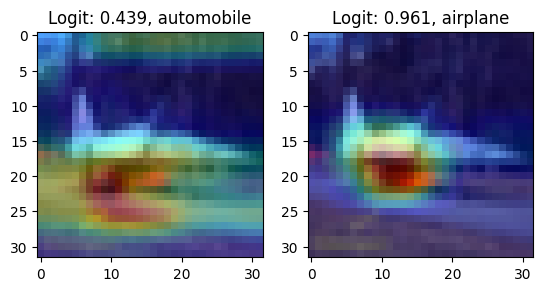

In [37]:
show_GradCAM_results(1)

1/1 [==============================] - 0s 19ms/step


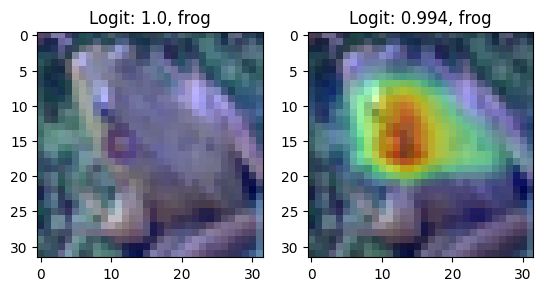

In [38]:
show_GradCAM_results(2)

1/1 [==============================] - 0s 24ms/step


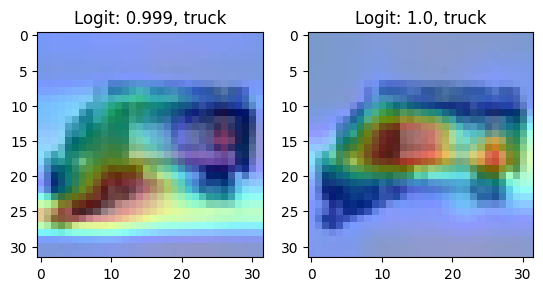

In [39]:
show_GradCAM_results(3)

1/1 [==============================] - 0s 23ms/step


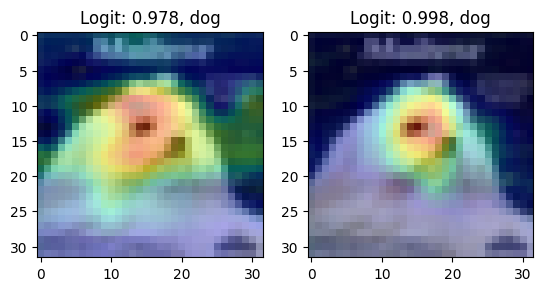

In [40]:
show_GradCAM_results(4)

1/1 [==============================] - 0s 18ms/step


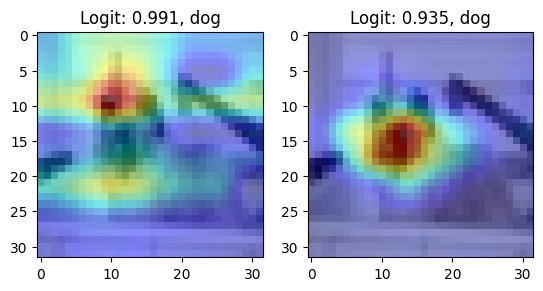

In [41]:
show_GradCAM_results(8)

1/1 [==============================] - 0s 29ms/step


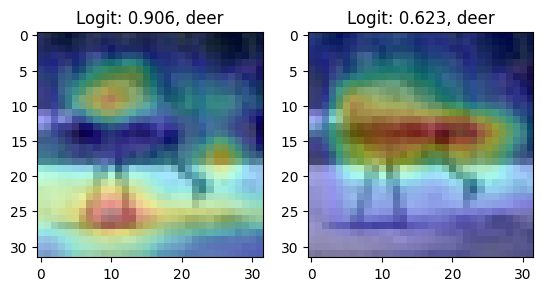

In [42]:
show_GradCAM_results(9)

1/1 [==============================] - 0s 18ms/step


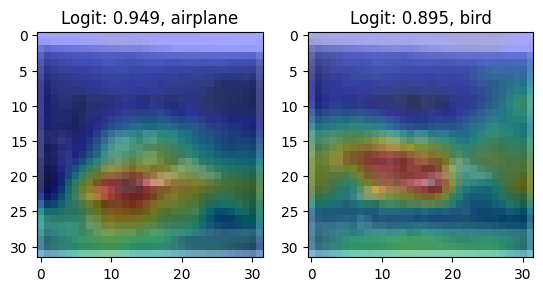

In [44]:
show_GradCAM_results(25)

1/1 [==============================] - 0s 31ms/step


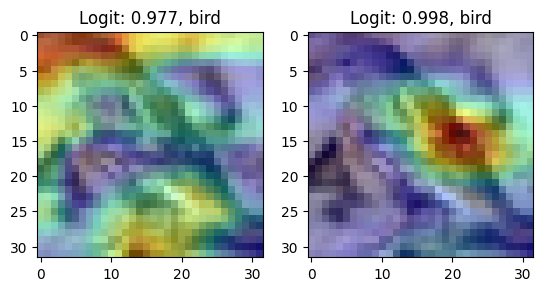

In [47]:
show_GradCAM_results(30)

### Reference

[EscVM_YT/Notebooks/0 - TF2.X Tutorials
/tf_2_visual_attention.ipynb](https://github.com/EscVM/EscVM_YT/blob/master/Notebooks/0%20-%20TF2.X%20Tutorials/tf_2_visual_attention.ipynb)

https://github.com/sicara/tf-explain/blob/master/tf_explain/core/grad_cam.py

https://github.com/sicara/tf-explain/blob/master/tf_explain/utils/display.py

https://github.com/sicara/tf-explain/blob/master/tf_explain/utils/saver.py

https://www.youtube.com/watch?v=1mjI_Jm4W1E
